# Getting started with Task 1

Instructions:
- Download the dataset from the [ECG Heartbeat Categorization Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat)
- Unzip the `archive.zip` file
- Rename the folder `archive` as `ecg_dataset` and place it in the root of the git repository

References:
- [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf)

#### Loading dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.regularizers import l1, l2
from keras.optimizers import SGD
import time
import xgboost

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import torch
import numpy as np
import os
import sklearn
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score,roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

print('libraries imported!')

/usr/workspace/azhar2/.conda/envs/python3.9/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorFlow version: 2.12.0
Num GPUs Available:  1
libraries imported!


## The PTB Diagnostic ECG Database

- Number of Samples: 14552
- Number of Categories: 2
- Sampling Frequency: 125Hz
- Data Source: Physionet's PTB Diagnostic Database
- ECG lead II re-sampled to the sampling frequency of 125Hz as the input (from [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf))
- Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.
- The final element of each row denotes the class to which that example belongs.


In [2]:
df_ptbd_normal = pd.read_csv("ptbdb_normal.csv", header = None)
df_ptbd_abnormal = pd.read_csv("ptbdb_abnormal.csv", header = None)


print("The shape of the normal dataframe is : ", df_ptbd_normal.shape)
print("Class : ", df_ptbd_normal.iloc[:, -1][0])
print("The shape of the abnormal dataframe is : ", df_ptbd_abnormal.shape)
print("Class : ", df_ptbd_abnormal.iloc[:, -1][0])

classes_names = {0 : "normal", 
                 1 : "abnormal"}

num_cols = df_ptbd_normal.shape[1] - 1 

The shape of the normal dataframe is :  (4046, 188)
Class :  0.0
The shape of the abnormal dataframe is :  (10506, 188)
Class :  1.0


The last time value is :  1488.0


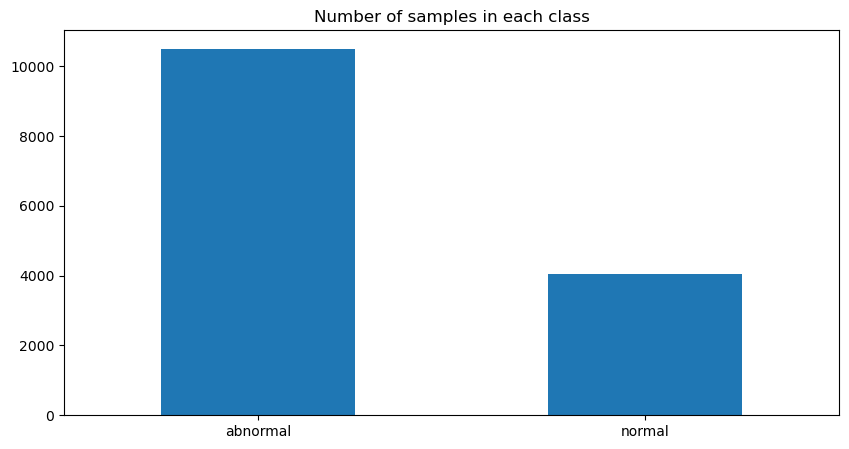

In [3]:
time = np.arange(0, num_cols) / 125
time = time * 1000
print("The last time value is : ", time[-1])

df_ptbd_normal.columns = list(time) + ["label"]
df_ptbd_abnormal.columns = list(time) + ["label"]
df_ptbd = pd.concat([df_ptbd_normal, df_ptbd_abnormal], axis = 0)
df_ptbd_original = df_ptbd.copy()

counts = df_ptbd["label"].value_counts()
counts.index = counts.index.map(classes_names)

plt.figure(figsize = (10, 5))
counts.plot(kind = "bar")
plt.xticks(rotation = 0)
plt.title("Number of samples in each class")
plt.show()

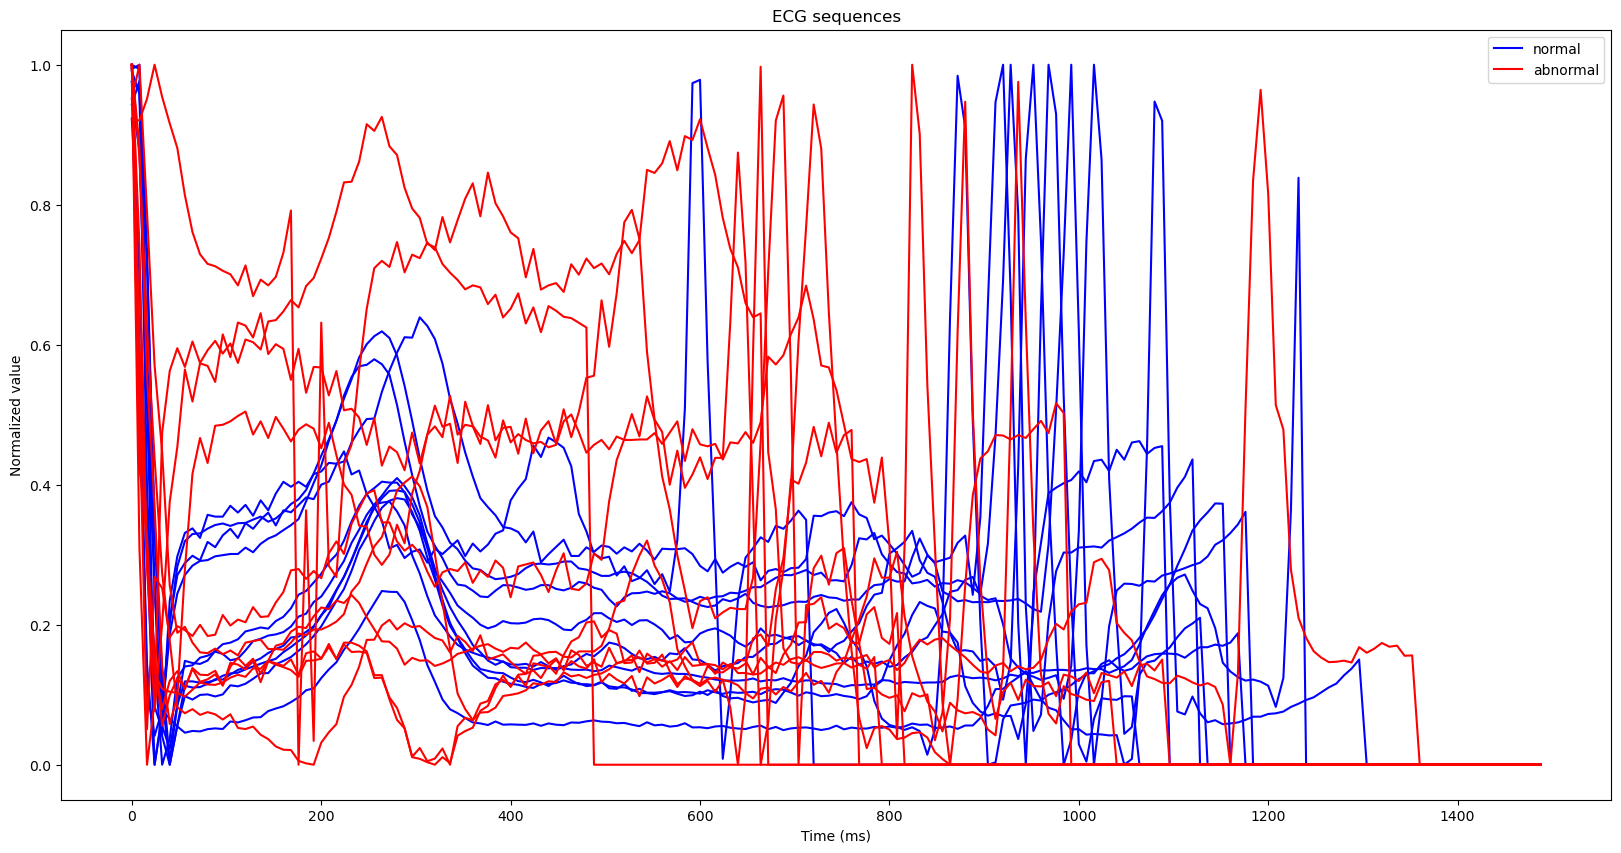

In [4]:

df_ptbd_normal = df_ptbd[df_ptbd["label"] == 0].sample(10)
df_ptbd_abnormal = df_ptbd[df_ptbd["label"] == 1].sample(10)
df_ptbd_normal_np,df_ptbd_abnormal_np = np.array(df_ptbd_normal),np.array(df_ptbd_abnormal)

plt.figure(figsize = (20, 10))

for i in range(df_ptbd_normal.shape[0]):
    
    Yy,Xx = np.reshape(df_ptbd_normal_np[i, 0:-1],(187,1)),np.reshape(df_ptbd_normal.columns[:-1],(187,1))
    if i == 0:
        plt.plot(Xx, Yy, color = "blue", label = "normal")
    else:
        plt.plot(Xx, Yy,color = "blue")
        
for i in range(df_ptbd_abnormal.shape[0]):
    
    Yy,Xx =np.reshape(df_ptbd_abnormal_np[i, 0:-1],(187,1)),np.reshape(df_ptbd_abnormal.columns[:-1],(187,1))
    
    if i == 0:
        plt.plot(Xx,Yy, color = "red", label = "abnormal")
    else:   
        plt.plot(Xx, Yy, color = "red")
plt.legend()
plt.title("ECG sequences")
plt.ylabel("Normalized value")
plt.xlabel("Time (ms)")
plt.show()
plt.close()

#### Preparing train test splits for model training:

In [5]:
Y = df_ptbd['label']
X = df_ptbd.drop('label',axis=1)
X = np.array(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42) #seeding the split for reproducible results
Y_train,Y_test = np.array(Y_train),np.array(Y_test)
Y_train = np.reshape(Y_train,(Y_train.shape[0],1))
Y_test = np.reshape(Y_test,(Y_test.shape[0],1))

pd_ytrain = pd.DataFrame(Y_train,columns=['label'])
pd_ytrain['set'] = 'train'

pd_ytest = pd.DataFrame(Y_test,columns=['label'])
pd_ytest['set'] = 'test'

pd_y = pd.concat((pd_ytrain,pd_ytest),axis=0)
pd_y['int_label'] = pd_y['label'].astype(int)
pivot_y = pd.pivot_table(pd_y,values='int_label',index='set',aggfunc='count',columns='label')
pivot_y_df = pivot_y.reset_index()

   label    set  count
0    0.0   test    834
1    0.0  train   3212
2    1.0   test   2077
3    1.0  train   8429


Text(0, 0.5, 'Number of samples')

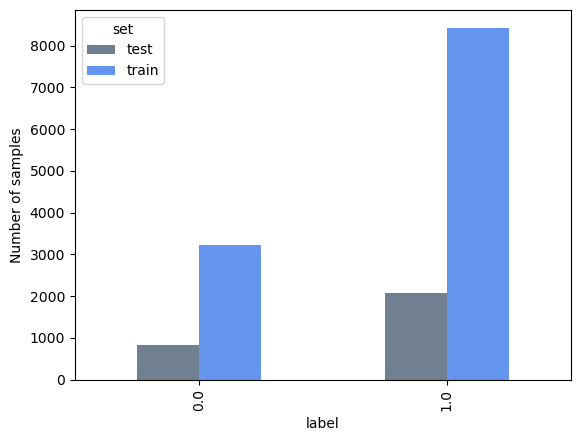

In [6]:
grouped_data = pd_y.groupby(['label', 'set']).size().reset_index(name='count')
print(grouped_data)
pivot_data = grouped_data.pivot(index='label', columns='set', values='count')
pivot_data.plot.bar(stacked=False,color=['slategray','cornflowerblue'])
plt.ylabel('Number of samples')

### Decision Tree Classifiers

In [7]:
import time
def decision_tree_classifier(X_train,X_test,Y_train,Y_test,cfr='DecisionTree',pca=False):
    start_time = time.time()
    
    if cfr == 'DecisionTree':
        
        print('Performing Decision Tree Classification with hyper-parameter tuning and cross-validation (5): ... ')
        classifier = DecisionTreeClassifier()
        param_grid = {
                      'criterion':['entropy'],
                      'max_depth':[3,5,10,None],
                      'min_samples_split':[5,10,15],
                      'min_samples_leaf':[1,5,10],
                      'class_weight' : ['balanced'],
                      'max_leaf_nodes':[None,10,50]}
        
    elif cfr == 'GradientBoosting':
        
        print('Performing Gradient Boosting Regression with hyper-parameter tuning and cross-validation (5): ... ')
        
        param_grid = {
            'booster': ['dart'],
            'objective': ['binary:logistic'],
            'max_depth': [1,5,8,10,None],
            'learning_rate': [0.01,0.05,0.08],
            'lambda': [1],
            'eval_metric': ['logloss'],   
            'eta': [0.05]
            }

        classifier = xgboost.XGBClassifier()
        print('param_grid')
        
    GridSearch = GridSearchCV(classifier,param_grid,cv=5) #hyperparameter tuning 
    GridSearch.fit(X_train,Y_train)
    best_params = GridSearch.best_params_
    best_score = GridSearch.best_score_
    best_model = GridSearch.best_estimator_
     
    print(f"Best parameters: {best_params}")
    print(f"Best score: {best_score}")
    
    best_model.fit(X_train, Y_train)

    y_pred = best_model.predict(X_train)
    score = accuracy_score(y_pred,Y_train)
    print("Train Score:", score)
   
    y_pred = best_model.predict(X_test)
    score = accuracy_score(y_pred,Y_test)
    print("Test Score:", score)

    print(f"{cfr} complete in {time.time()-start_time} seconds!")
    return best_model 


In [8]:
decision_tree_model = decision_tree_classifier(X_train,X_test,Y_train,Y_test,cfr='DecisionTree')
print('\n')

yhat_test = decision_tree_model.predict(X_test)

print("Test Set Metrics for DecisionTree Classifier: ")

print(f"Test Set Accuracy: {accuracy_score(yhat_test,Y_test)}")
precision = precision_score(yhat_test,Y_test)
print(f"Precision Score: {precision}")

recall = recall_score(yhat_test,Y_test)
print(f"Recall Score: {recall}")

f1 = f1_score(yhat_test,Y_test)
print(f"F1 Score: {f1}")

logloss = log_loss(yhat_test,Y_test)
print(f"Log Loss: {logloss}")

# Plotting ROC CURVES:
fpr_decision_tree, tpr_decision_tree, thresholds_decision_tree = roc_curve(yhat_test, Y_test)

# Calculate the area under the ROC curve (AUC)
roc_auc_decision_tree = auc(fpr_decision_tree, tpr_decision_tree)


Performing Decision Tree Classification with hyper-parameter tuning and cross-validation (5): ... 
Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best score: 0.9223430037226722
Train Score: 0.9975947083583885
Test Score: 0.9230504981106149
DecisionTree complete in 927.5517370700836 seconds!


Test Set Metrics for DecisionTree Classifier: 
Test Set Accuracy: 0.9230504981106149
Precision Score: 0.9518536350505536
Recall Score: 0.9409804854831033
F1 Score: 0.9463858305409287
Log Loss: 2.7735411745662115


In [10]:
xgboost_tree_model = decision_tree_classifier(X_train,X_test,Y_train,Y_test,cfr='GradientBoosting')
print('\n')
yhat_test = xgboost_tree_model.predict(X_test)

print("Test Set Metrics for DecisionTree Classifier: ")

print(f"Test Set Accuracy: {accuracy_score(yhat_test,Y_test)}")
precision = precision_score(yhat_test,Y_test)
print(f"Precision Score: {precision}")

recall = recall_score(yhat_test,Y_test)
print(f"Recall Score: {recall}")

f1 = f1_score(yhat_test,Y_test)
print(f"F1 Score: {f1}")

logloss = log_loss(yhat_test,Y_test)
print(f"Log Loss: {logloss}")

# Plotting ROC CURVES:
fpr_gbm, tpr_gbm, thresholds_gbm = roc_curve(yhat_test, Y_test)

# Calculate the area under the ROC curve (AUC)
roc_auc_gbm = auc(fpr_gbm, tpr_gbm)

Performing Gradient Boosting Regression with hyper-parameter tuning and cross-validation (5): ... 
param_grid
Best parameters: {'booster': 'dart', 'eta': 0.05, 'eval_metric': 'logloss', 'lambda': 1, 'learning_rate': 0.08, 'max_depth': 10, 'objective': 'binary:logistic'}
Best score: 0.97251073053196
Train Score: 0.9998281934541706
Test Score: 0.9742356578495363
GradientBoosting complete in 391.5232346057892 seconds!


Test Set Metrics for DecisionTree Classifier: 
Test Set Accuracy: 0.9742356578495363
Precision Score: 0.9874819451131439
Recall Score: 0.9766666666666667
F1 Score: 0.9820445295666747
Log Loss: 0.9286410182699371


### Logistic Regression

In [11]:
def logistic_regression(X_train,X_test,Y_train,Y_test,penalty=None):
    
    start_time = time.time()
    param_grid = {
        'penalty': ['l1','l2','None'],
        'C' : [1.0,10,50,100],
        'class_weight':['balanced'],
        'solver':['saga'], #supports L1, L2, No regularization
    }
    
    classifier = LogisticRegression(random_state=0)
    GridSearch = GridSearchCV(classifier,param_grid,cv=5) #hyperparameter tuning 
    GridSearch.fit(X_train,Y_train)
    best_params = GridSearch.best_params_
    best_score = GridSearch.best_score_
    best_model = GridSearch.best_estimator_
    
    print(f"Best parameters: {best_params}")
    print(f"Best score: {best_score}")
    
    best_model.fit(X_train, Y_train)

    y_pred = best_model.predict(X_train)
    score = accuracy_score(y_pred,Y_train)
    print("Train Score:", score)
   
    y_pred = best_model.predict(X_test)
    score = accuracy_score(y_pred,Y_test)
    print("Test Score:", score)

    print(f"Logistic Regression complete in {time.time()-start_time} seconds!")
    return best_model

In [12]:
import warnings
warnings.filterwarnings("ignore")
log_regression_model = logistic_regression(X_train,X_test,Y_train,Y_test)
yhat_test = log_regression_model.predict(X_test)

print("Test Set Metrics for Logistic Regression Classifier: ")

print(f"Test Set Accuracy: {accuracy_score(yhat_test,Y_test)}")
precision = precision_score(yhat_test,Y_test)
print(f"Precision Score: {precision}")

recall = recall_score(yhat_test,Y_test)
print(f"Recall Score: {recall}")

f1 = f1_score(yhat_test,Y_test)
print(f"F1 Score: {f1}")

logloss = log_loss(yhat_test,Y_test)
print(f"Log Loss: {logloss}")

# Plotting ROC CURVES:
fpr_logistic, tpr_logistic, thresholds_logistics = roc_curve(yhat_test, Y_test)

# Calculate the area under the ROC curve (AUC)
roc_logistic = auc(fpr_logistic, tpr_logistic)

Best parameters: {'C': 50, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}
Best score: 0.7816342279254993
Train Score: 0.7892792715402457
Test Score: 0.8024733768464445
Logistic Regression complete in 120.8556318283081 seconds!
Test Set Metrics for Logistic Regression Classifier: 
Test Set Accuracy: 0.8024733768464445
Precision Score: 0.7833413577274916
Recall Score: 0.9286529680365296
F1 Score: 0.8498302428832593
Log Loss: 7.119581140069516


In [13]:
roc_logistic

0.770193610851742

### Deep Neural Networks


In [14]:
# Define NN
def neural_net(X_train,X_test,Y_train,Y_test):
    
    model = Sequential()
    model.add(Dense(X_train.shape[0], input_dim=(X_train.shape[1]), activation='relu'))#, kernel_regularizer=l2(1)))
    #model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))#, kernel_regularizer=l2(1))) 
    #model.add(Dropout(0.2))
    model.add(Dense(30, activation='relu'))#, kernel_regularizer=l2(1))) 
    #model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid')) 

    sgd = SGD(learning_rate=0.01,momentum=0.9)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy']) 

    # Fit and predict with NN
    print(f"Training Neural Network:")
    start_time = time.time()
    model.fit(X_train, Y_train, epochs=200, batch_size=50, verbose=0)
    print(f"Model Trained in {time.time()-start_time} seconds")
    
    from sklearn.metrics import accuracy_score
    yhat_train = model.predict(X_train)
    yhat_train = np.round(yhat_train)
    #yhat_train = np.argmax(yhat_train,axis=1)
    print(f"Train Set Accuracy: {accuracy_score(yhat_train,Y_train)}\n")

    yhat_test = model.predict(X_test)
    yhat_test = np.round(yhat_test)
    #yhat_test = np.argmax(yhat_test,axis=1)
    print(f"Test Set Accuracy: {accuracy_score(yhat_test,Y_test)}")
    return model

In [15]:
model_nn = neural_net(X_train,X_test,Y_train,Y_test)
yhat_test = model_nn.predict(X_test)
yhat_test = np.round(yhat_test)
print('\n')

print("Test Set Metrics for Neural Network: ")

#yhat_test = np.argmax(yhat_test,axis=1)
print(f"Test Set Accuracy: {accuracy_score(yhat_test,Y_test)}")

precision = precision_score(yhat_test,Y_test)
print(f"Precision Score: {precision}")

recall = recall_score(yhat_test,Y_test)
print(f"Recall Score: {recall}")

f1 = f1_score(yhat_test,Y_test)
print(f"F1 Score: {f1}")

logloss = log_loss(yhat_test,Y_test)
print(f"Log Loss: {logloss}")

# Plotting ROC CURVES:
fpr_nn, tpr_nn, thresholds_nn = roc_curve(yhat_test, Y_test)

# Calculate the area under the ROC curve (AUC)
roc_nn = auc(fpr_nn, tpr_nn)

Training Neural Network:
Model Trained in 121.26186156272888 seconds
364/364 [==============================] - 1s 1ms/step
Train Set Accuracy: 1.0

91/91 [==============================] - 0s 1ms/step
Test Set Accuracy: 0.9821367227756784
91/91 [==============================] - 0s 1ms/step


Test Set Metrics for Neural Network: 
Test Set Accuracy: 0.9821367227756784
Precision Score: 0.9908521906596052
Recall Score: 0.9842180774748924
F1 Score: 0.9875239923224568
Log Loss: 0.6438577726671565


In [16]:
model_nn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 11641)             2188508   
                                                                 
 dense_1 (Dense)             (None, 50)                582100    
                                                                 
 dense_2 (Dense)             (None, 30)                1530      
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 2,772,169
Trainable params: 2,772,169
Non-trainable params: 0
_________________________________________________________________


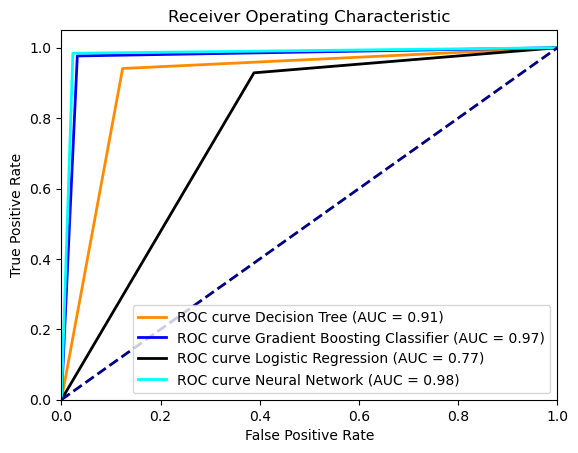

In [17]:
# Plot ROC curve
plt.figure()
plt.plot(fpr_decision_tree, tpr_decision_tree, color='darkorange', lw=2, label='ROC curve Decision Tree (AUC = %0.2f)' % roc_auc_decision_tree)
plt.plot(fpr_gbm, tpr_gbm, color='blue', lw=2, label='ROC curve Gradient Boosting Classifier (AUC = %0.2f)' % roc_auc_gbm)
plt.plot(fpr_logistic, tpr_logistic, color='black', lw=2, label='ROC curve Logistic Regression (AUC = %0.2f)' % roc_logistic)
plt.plot(fpr_nn, tpr_nn, color='cyan', lw=2, label='ROC curve Neural Network (AUC = %0.2f)' % roc_nn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()